# Multilingual NER Analysis

In [1]:
from gensim.models import KeyedVectors
from nltk.corpus.reader.conll import ConllCorpusReader
import re
from math import floor
import numpy as np
import sys
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from keras.layers.recurrent import LSTM
from keras.models import Sequential, Model
from keras.layers import Dense, Bidirectional, Flatten, Dropout, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
import keras.backend as K
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


Define function to plot confusion matrices.

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load the Data from File
Load all of the X and y data (from preprocessing step) in every language.

In [3]:
X_en_train = np.load('data/eng.X.train.npy', mmap_mode='r')
y_en_train_label = np.load('data/eng.y.train.npy', mmap_mode='r')

In [4]:
X_en_test = np.load('data/eng.X.testa.npy', mmap_mode='r')
y_en_test_label = np.load('data/eng.y.testa.npy', mmap_mode='r')

In [5]:
X_de_test = np.load('data/deu.X.testa.npy', mmap_mode='r')
y_de_test_label = np.load('data/deu.y.testa.npy', mmap_mode='r')

In [6]:
X_de_train = np.load('data/deu.X.train.npy', mmap_mode='r')
y_de_train_label = np.load('data/deu.y.train.npy', mmap_mode='r')

In [7]:
X_es_test = np.load('data/esp.X.testa.npy', mmap_mode='r')
y_es_test_label = np.load('data/esp.y.testa.npy', mmap_mode='r')

In [8]:
X_es_train = np.load('data/esp.X.train.npy', mmap_mode='r')
y_es_train_label = np.load('data/esp.y.train.npy', mmap_mode='r')

### Encode the Target
Get the classes from the y arrays and encode the labels for prediction and training.

In [9]:
train_en_classes = set()
for sent in y_en_train_label:
    for label in sent:
        train_en_classes.add(label)
        
test_en_classes = set()
for sent in y_en_test_label:
    for label in sent:
        test_en_classes.add(label)
        
train_de_classes = set()
for sent in y_de_train_label:
    for label in sent:
        train_de_classes.add(label)
        
test_de_classes = set()
for sent in y_de_test_label:
    for label in sent:
        test_de_classes.add(label)
        
train_es_classes = set()
for sent in y_es_train_label:
    for label in sent:
        train_es_classes.add(label)
        
test_es_classes = set()
for sent in y_es_test_label:
    for label in sent:
        test_es_classes.add(label)

classes = ['B-MISC', 'I-MISC', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'O']
print("Classes:", classes)
print("Missing in English training:", 
      test_en_classes.difference(train_en_classes),
      test_de_classes.difference(train_en_classes), 
      test_es_classes.difference(train_en_classes))
print("Missing in German training:", 
      test_en_classes.difference(train_de_classes),
      test_de_classes.difference(train_de_classes), 
      test_es_classes.difference(train_de_classes))

print("Missing in Spanish training:", 
      test_en_classes.difference(train_es_classes),
      test_de_classes.difference(train_es_classes), 
      test_es_classes.difference(train_es_classes))

num_classes = len(classes)
encoded_classes = range(num_classes)
class2idx = {classes[enc]: enc for enc in encoded_classes}


Classes: ['B-MISC', 'I-MISC', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'O']
Missing in English training: set() set() set()
Missing in German training: set() set() set()
Missing in Spanish training: set() set() set()


### Create a Binary Variation of the Task
Convert tags to B-NE and I-NE.

In [10]:
def lab2bin(y_labels):
    y_bin = np.copy(y_labels)
    for i in range(len(y_bin)):
        for j in range(len(y_bin[i])):
            if y_bin[i][j] != 'O':
                if y_bin[i][j][0] == 'B':
                    y_bin[i][j] = 'B-NE'
                else:
                    y_bin[i][j] = 'I-NE'
    return y_bin

In [11]:
y_en_train_bin_label = lab2bin(y_en_train_label)              
y_en_test_bin_label = lab2bin(y_en_test_label)
 
y_de_train_bin_label = lab2bin(y_de_train_label)
y_de_test_bin_label = lab2bin(y_de_test_label)

y_es_train_bin_label = lab2bin(y_es_train_label)
y_es_test_bin_label = lab2bin(y_es_test_label)


bin_classes = ['O', 'B-NE', 'I-NE']
bin_num_classes = len(bin_classes)
bin_encoded_classes = range(bin_num_classes)
binclass2idx = {bin_classes[enc]: enc for enc in bin_encoded_classes}

### Convert the Labels to Categorical Arrays
Encode the labels for use with the model.

In [12]:
y_en_train = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_en_train_label])
y_en_test = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_en_test_label])
y_de_train = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_de_train_label])
y_de_test = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_de_test_label])
y_es_train = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_es_train_label])
y_es_test = np.array([np.array(to_categorical([class2idx[cls] for cls in sent], num_classes=num_classes)) for sent in y_es_test_label])

y_en_train_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_en_train_bin_label])
y_en_test_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_en_test_bin_label])
y_de_train_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_de_train_bin_label])
y_de_test_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_de_test_bin_label])
y_es_train_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_es_train_bin_label])
y_es_test_bin = np.array([np.array(to_categorical([binclass2idx[cls] for cls in sent], num_classes=bin_num_classes)) for sent in y_es_test_bin_label])


### Combine the Languages
Create a multilingual training set.

In [13]:
X_train = np.vstack([X_en_train, X_de_train, X_es_train])
y_train = np.vstack([y_en_train, y_de_train, y_es_train])
y_train_bin = np.vstack([y_en_train_bin, y_de_train_bin, y_es_train_bin])

In [14]:
np.save('data/full.X.train.npy', X_train)
np.save('data/full.y.train.npy', y_train)

## Create the Model
Define, train and save the model.

In [15]:
dropout = 0.1
recurrent_dropout = 0.3
window_size = X_en_train[0].shape[0]
num_features = X_en_train[0].shape[1]
hidden_nodes = 100

def create_model(num_classes, num_features, hidden_nodes=100):
    model = Sequential()
    model.add(Bidirectional(
        LSTM(units=num_features, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout),
        input_shape=(window_size, num_features,),
        merge_mode='concat'))
    model.add(TimeDistributed(Dense(hidden_nodes, activation='relu')))
    # add a CRF layer to enforce NER IOB rules
    crf = CRF(num_classes, sparse_target=False)
    model.add(crf)
    print("Summary:", model.summary())
    model.compile(optimizer='rmsprop', loss=crf.loss_function, metrics=[crf.accuracy])
    return model

In [16]:
print("X shape:", X_en_train.shape)
print("y shape:", y_en_train.shape)
model = create_model(num_classes, num_features)
model.fit(X_en_train, y_en_train, batch_size=50, epochs=10)

X shape: (11376, 70, 300)
y shape: (11376, 70, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_1 (CRF)                  (None, 70, 9)             1008      
Total params: 1,503,508
Trainable params: 1,503,508
Non-trainable params: 0
_________________________________________________________________
Summary: None
Epoch 1/10
11376/11376 [==============================] - 429s 38ms/step - loss: 0.1645 - acc: 0.9605
Epoch 2/10
11376/11376 [==============================] - 214s 19ms/step - loss: 0.0648 - acc: 0.9829
Epoch 3/10
11376/11376 [==============================] - 204s 18ms/step - loss: 0.0451 - acc: 0.9862
Epoch 4/10
11376/11376 [==

In [17]:
save_load_utils.save_all_weights(model,'models/eng_train.h5')

# Analysis
Analyze results from English training, train on all languages, then analyze the result from full training.

In [18]:
def arr2label(cats, labels):
    new_labels = []
    for i in range(len(cats)):
        sent_labels = []
        for j in range(len(cats[i])):
            label = np.argmax(cats[i][j])
            label = labels[label]
            new_labels.append(label)
    return new_labels

### English Results from English Training

2701/2701 [==============================] - 24s 9ms/step
loss: 0.00558129110143
acc: 0.9895171093
Precision: 0.886639307127
Recall: 0.742196944215
F1: 0.8006410933


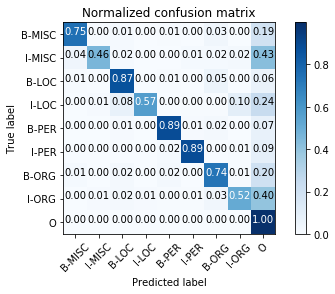

In [19]:
y_pred_en = model.predict(X_en_test)
score_en = model.evaluate(X_en_test, y_en_test)
for i in range(len(score_en)):
    print(str(model.metrics_names[i]) + ': ' + str(score_en[i]))
y_pred_en_label = arr2label(y_pred_en, classes)
y_true_en_label = arr2label(y_en_test, classes)

precision = precision_score(y_true_en_label, y_pred_en_label, average='macro')
recall = recall_score(y_true_en_label, y_pred_en_label, average='macro')
f1 = f1_score(y_true_en_label, y_pred_en_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_en_label, y_pred_en_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

### German Results from English Training

2644/2644 [==============================] - 24s 9ms/step
loss: 0.319777492361
acc: 0.868413660151
Precision: 0.224301435574
Recall: 0.344360246077
F1: 0.218689208774


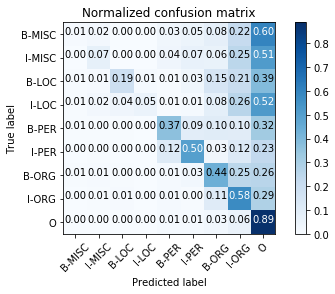

In [20]:
y_pred_de = model.predict(X_de_test)
score_de = model.evaluate(X_de_test, y_de_test)
for i in range(len(score_de)):
    print(str(model.metrics_names[i]) + ': ' + str(score_de[i]))
y_pred_de_label = arr2label(y_pred_de, classes)
y_true_de_label = arr2label(y_de_test, classes)

precision = precision_score(y_true_de_label, y_pred_de_label, average='macro')
recall = recall_score(y_true_de_label, y_pred_de_label, average='macro')
f1 = f1_score(y_true_de_label, y_pred_de_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_de_label, y_pred_de_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

### Spanish Results from English Training

1588/1588 [==============================] - 14s 9ms/step
loss: 0.119082768502
acc: 0.95370636719
Precision: 0.585328461802
Recall: 0.4016036985
F1: 0.45151538207


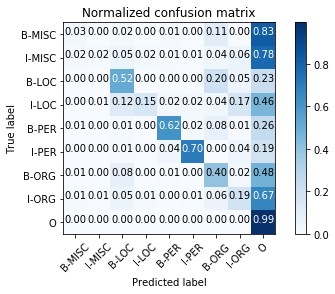

In [21]:
y_pred_es = model.predict(X_es_test)
score_es = model.evaluate(X_es_test, y_es_test)
for i in range(len(score_es)):
    print(str(model.metrics_names[i]) + ': ' + str(score_es[i]))
y_pred_es_label = arr2label(y_pred_es, classes)
y_true_es_label = arr2label(y_es_test, classes)

precision = precision_score(y_true_es_label, y_pred_es_label, average='macro')
recall = recall_score(y_true_es_label, y_pred_es_label, average='macro')
f1 = f1_score(y_true_es_label, y_pred_es_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_es_label, y_pred_es_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

## Train the Binary Task on English
Repeat above steps with the binary lables.

In [22]:
model = create_model(bin_num_classes, num_features)
model.fit(X_en_train, y_en_train_bin, batch_size=50, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_2 (CRF)                  (None, 70, 3)             318       
Total params: 1,502,818
Trainable params: 1,502,818
Non-trainable params: 0
_________________________________________________________________
Summary: None
Epoch 1/10
11376/11376 [==============================] - 429s 38ms/step - loss: 0.1122 - acc: 0.9670
Epoch 2/10
11376/11376 [==============================] - 237s 21ms/step - loss: 0.0505 - acc: 0.9867
Epoch 3/10
11376/11376 [==============================] - 217s 19ms/step - loss: 0.0387 - acc: 0.9886
Epoch 4/10
11376/11376 [==============================] - 208s 18ms/step - l

In [23]:
save_load_utils.save_all_weights(model,'models/eng_train_bin.h5')

### Binary English Results from English Training

2701/2701 [==============================] - 22s 8ms/step
loss: 0.00415648656433
acc: 0.991331252775
Precision: 0.939208771327
Recall: 0.880985488001
F1: 0.908374361826


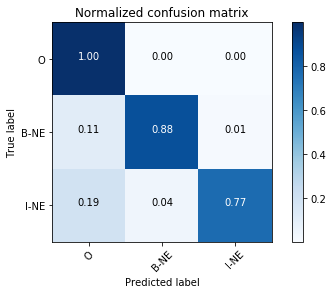

In [24]:
y_pred_en = model.predict(X_en_test)
score_en = model.evaluate(X_en_test, y_en_test_bin)
for i in range(len(score_en)):
    print(str(model.metrics_names[i]) + ': ' + str(score_en[i]))
y_pred_en_label = arr2label(y_pred_en, bin_classes)
y_true_en_label = arr2label(y_en_test_bin, bin_classes)

precision = precision_score(y_true_en_label, y_pred_en_label, average='macro')
recall = recall_score(y_true_en_label, y_pred_en_label, average='macro')
f1 = f1_score(y_true_en_label, y_pred_en_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_en_label, y_pred_en_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

### Binary German Results from English Training

2644/2644 [==============================] - 20s 8ms/step
loss: 0.32248837901
acc: 0.869829264603
Precision: 0.404159988378
Recall: 0.594432266786
F1: 0.423600528397


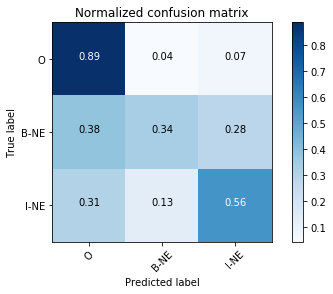

In [25]:
y_pred_de = model.predict(X_de_test)
score_de = model.evaluate(X_de_test, y_de_test_bin)
for i in range(len(score_de)):
    print(str(model.metrics_names[i]) + ': ' + str(score_de[i]))
y_pred_de_label = arr2label(y_pred_de, bin_classes)
y_true_de_label = arr2label(y_de_test_bin, bin_classes)

precision = precision_score(y_true_de_label, y_pred_de_label, average='macro')
recall = recall_score(y_true_de_label, y_pred_de_label, average='macro')
f1 = f1_score(y_true_de_label, y_pred_de_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_de_label, y_pred_de_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

### Binary Spanish Results from English Training

1588/1588 [==============================] - 11s 7ms/step
loss: 0.0919879165945
acc: 0.960525367362
Precision: 0.832088497565
Recall: 0.652746121141
F1: 0.717169875022


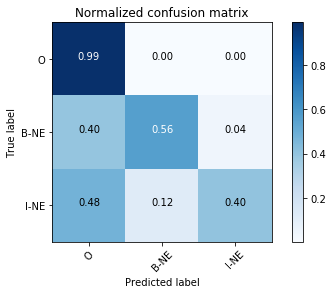

In [26]:
y_pred_es = model.predict(X_es_test)
score_es = model.evaluate(X_es_test, y_es_test_bin)
for i in range(len(score_es)):
    print(str(model.metrics_names[i]) + ': ' + str(score_es[i]))
y_pred_es_label = arr2label(y_pred_es, bin_classes)
y_true_es_label = arr2label(y_es_test_bin, bin_classes)

precision = precision_score(y_true_es_label, y_pred_es_label, average='macro')
recall = recall_score(y_true_es_label, y_pred_es_label, average='macro')
f1 = f1_score(y_true_es_label, y_pred_es_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_es_label, y_pred_es_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

# Train on Every Language
Repeat above analysis after training the model on the multilingual training set.

In [27]:
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)
model = create_model(num_classes, num_features)
model.fit(X_train, y_train, batch_size=50, epochs=10)

X shape: (29407, 70, 300)
y shape: (29407, 70, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_3 (CRF)                  (None, 70, 9)             1008      
Total params: 1,503,508
Trainable params: 1,503,508
Non-trainable params: 0
_________________________________________________________________
Summary: None
Epoch 1/10
29407/29407 [==============================] - 559s 19ms/step - loss: 0.1424 - acc: 0.9666
Epoch 2/10
29407/29407 [==============================] - 561s 19ms/step - loss: 0.0631 - acc: 0.9787
Epoch 3/10
29407/29407 [==============================] - 582s 20ms/step - loss: 0.0394 - acc: 0.9809
Epoch 4/10
29407/29407 [==

### Save the Model

In [28]:
save_load_utils.save_all_weights(model,'models/full_train.h5')

### English Results from Full Training

2701/2701 [==============================] - 22s 8ms/step
loss: -0.0545154537982
acc: 0.989675777989
Precision: 0.878507986534
Recall: 0.74098531526
F1: 0.791897896506


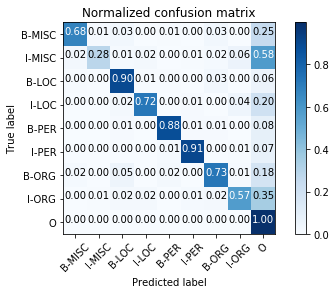

In [29]:
y_pred_en = model.predict(X_en_test)
score_en = model.evaluate(X_en_test, y_en_test)
for i in range(len(score_en)):
    print(str(model.metrics_names[i]) + ': ' + str(score_en[i]))
y_pred_en_label = arr2label(y_pred_en, classes)
y_true_en_label = arr2label(y_en_test, classes)

precision = precision_score(y_true_en_label, y_pred_en_label, average='macro')
recall = recall_score(y_true_en_label, y_pred_en_label, average='macro')
f1 = f1_score(y_true_en_label, y_pred_en_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_en_label, y_pred_en_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

### German Results from Full Training

2644/2644 [==============================] - 21s 8ms/step
loss: -0.00298255991681
acc: 0.978798357063
Precision: 0.723325839937
Recall: 0.440117673467
F1: 0.516590833488


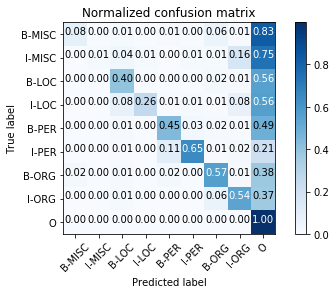

In [30]:
y_pred_de = model.predict(X_de_test)
score_de = model.evaluate(X_de_test, y_de_test)
for i in range(len(score_de)):
    print(str(model.metrics_names[i]) + ': ' + str(score_de[i]))
y_pred_de_label = arr2label(y_pred_de, classes)
y_true_de_label = arr2label(y_de_test, classes)

precision = precision_score(y_true_de_label, y_pred_de_label, average='macro')
recall = recall_score(y_true_de_label, y_pred_de_label, average='macro')
f1 = f1_score(y_true_de_label, y_pred_de_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_de_label, y_pred_de_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

### Spanish Results from Full Training

1588/1588 [==============================] - 13s 8ms/step
loss: -0.0263544721247
acc: 0.975458795238
Precision: 0.816602116039
Recall: 0.679990360087
F1: 0.72253764882


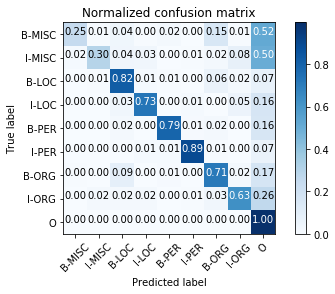

In [31]:
y_pred_es = model.predict(X_es_test)
score_es = model.evaluate(X_es_test, y_es_test)
for i in range(len(score_es)):
    print(str(model.metrics_names[i]) + ': ' + str(score_es[i]))
y_pred_es_label = arr2label(y_pred_es, classes)
y_true_es_label = arr2label(y_es_test, classes)

precision = precision_score(y_true_es_label, y_pred_es_label, average='macro')
recall = recall_score(y_true_es_label, y_pred_es_label, average='macro')
f1 = f1_score(y_true_es_label, y_pred_es_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_es_label, y_pred_es_label, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

## Binary Task with Full Training

In [32]:
print("X shape:", X_train.shape)
print("y shape:", y_train_bin.shape)
model = create_model(bin_num_classes, num_features)
model.fit(X_train, y_train_bin, batch_size=50, epochs=10)

X shape: (29407, 70, 300)
y shape: (29407, 70, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_4 (CRF)                  (None, 70, 3)             318       
Total params: 1,502,818
Trainable params: 1,502,818
Non-trainable params: 0
_________________________________________________________________
Summary: None
Epoch 1/10
29407/29407 [==============================] - 506s 17ms/step - loss: 0.1048 - acc: 0.9708
Epoch 2/10
29407/29407 [==============================] - 492s 17ms/step - loss: 0.0525 - acc: 0.9812
Epoch 3/10
29407/29407 [==============================] - 496s 17ms/step - loss: 0.0355 - acc: 0.9830
Epoch 4/10
29407/29407 [==

In [33]:
save_load_utils.save_all_weights(model,'models/full_train_bin.h5')

### Binary English Results from Full Training

2701/2701 [==============================] - 21s 8ms/step
loss: -0.046271091776
acc: 0.991362987779
Precision: 0.946607395434
Recall: 0.874036243434
F1: 0.907398073225


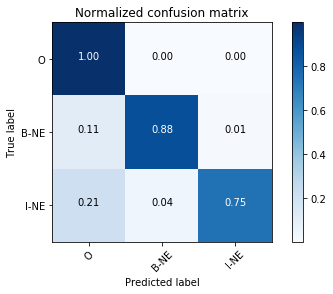

In [34]:
y_pred_en = model.predict(X_en_test)
score_en = model.evaluate(X_en_test, y_en_test_bin)
for i in range(len(score_en)):
    print(str(model.metrics_names[i]) + ': ' + str(score_en[i]))
y_pred_en_label = arr2label(y_pred_en, bin_classes)
y_true_en_label = arr2label(y_en_test_bin, bin_classes)

precision = precision_score(y_true_en_label, y_pred_en_label, average='macro')
recall = recall_score(y_true_en_label, y_pred_en_label, average='macro')
f1 = f1_score(y_true_en_label, y_pred_en_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_en_label, y_pred_en_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

### Binary German Results from Full Training

2644/2644 [==============================] - 20s 7ms/step
loss: -0.00814453596404
acc: 0.979662849124
Precision: 0.873563572806
Recall: 0.659072299383
F1: 0.737408238983


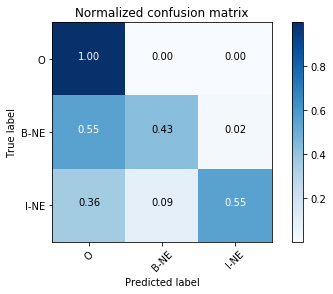

In [35]:
y_pred_de = model.predict(X_de_test)
score_de = model.evaluate(X_de_test, y_de_test_bin)
for i in range(len(score_de)):
    print(str(model.metrics_names[i]) + ': ' + str(score_de[i]))
y_pred_de_label = arr2label(y_pred_de, bin_classes)
y_true_de_label = arr2label(y_de_test_bin, bin_classes)

precision = precision_score(y_true_de_label, y_pred_de_label, average='macro')
recall = recall_score(y_true_de_label, y_pred_de_label, average='macro')
f1 = f1_score(y_true_de_label, y_pred_de_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_de_label, y_pred_de_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')

### Binary Spanish Results from Full Training

1588/1588 [==============================] - 12s 7ms/step
loss: -0.027583701485
acc: 0.98021769929
Precision: 0.885284991938
Recall: 0.874182579689
F1: 0.879396351399


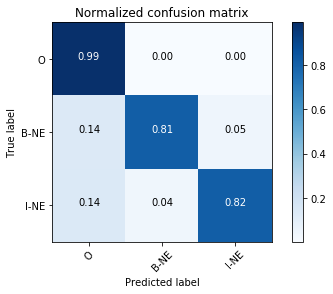

In [36]:
y_pred_es = model.predict(X_es_test)
score_es = model.evaluate(X_es_test, y_es_test_bin)
for i in range(len(score_es)):
    print(str(model.metrics_names[i]) + ': ' + str(score_es[i]))
y_pred_es_label = arr2label(y_pred_es, bin_classes)
y_true_es_label = arr2label(y_es_test_bin, bin_classes)

precision = precision_score(y_true_es_label, y_pred_es_label, average='macro')
recall = recall_score(y_true_es_label, y_pred_es_label, average='macro')
f1 = f1_score(y_true_es_label, y_pred_es_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

cnf_matrix = confusion_matrix(y_true_es_label, y_pred_es_label, labels=bin_classes)
plot_confusion_matrix(cnf_matrix, classes=bin_classes, normalize=True,
                      title='Normalized confusion matrix')